# Assignment 2: Logistic Regression

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [7]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [10]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [13]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
pickle_file=open('logistic.pickle','ab')
pickle.dump(preprocessed_essays,pickle_file)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:52<00:00, 2095.44it/s]


In [17]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [20]:
# similarly you can preprocess the titles also
from tqdm import tqdm
preprocessed_title = []
for sentence in tqdm(project_data['project_title'].values):
    sent=decontracted(sentence)
    sent=sent.replace('\\r',' ')
    sent=sent.replace('\\"',' ')
    sent=sent.replace('\\n',' ')
    sent=re.sub('[^A-za-z0-9]+',' ',sent)
    sent=' '.join(e for e in sent.split() if e.lower not in stopwords)
    preprocessed_title.append(sent.lower().strip())
pickle_file=open('logistic.pickle','ab')
pickle.dump(preprocessed_title,pickle_file)
pickle_file.close()

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 37871.98it/s]


In [21]:
print(preprocessed_title[60000])

listening center for learning


## 1.5 Preparing data for models

In [22]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

#### Using Pretrained Models: Avg W2V

In [480]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
# Loading pretrained model
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### Merging resource and project data file

In [25]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [353]:
X=project_data.copy()
X=X.drop(['id','Unnamed: 0','teacher_id','project_submitted_datetime','project_essay_1', 'project_essay_2', 'project_essay_3','project_essay_4','quantity'],axis=1)
del X['essay']
del X['project_title']
X['essay']=preprocessed_essays
X['project_title']=preprocessed_title
X=X.dropna(subset=['teacher_prefix']).reset_index(drop=True)
y=X['project_is_approved']


<h1>2. Logistic Regression </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [464]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,stratify=y)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.33,stratify=y_train)


In [465]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_cv.shape)
print(y_cv.shape)

(49039, 11)
(49039,)
(36051, 11)
(36051,)
(24155, 11)
(24155,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [466]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()
vectorizer.fit(X_train['school_state'])
X_train_school_state=vectorizer.transform(X_train['school_state'])
X_test_school_state=vectorizer.transform(X_test['school_state'])
X_cv_school_state=vectorizer.transform(X_cv['school_state'])

print(X_train_school_state.shape,y_train.shape)
print(X_test_school_state.shape,y_test.shape)
print(X_cv_school_state.shape,y_cv.shape)


(49039, 51) (49039,)
(36051, 51) (36051,)
(24155, 51) (24155,)


In [467]:
vectorizer=CountVectorizer()
vectorizer.fit(X_train['clean_categories'])
X_train_clean_categories=vectorizer.transform(X_train['clean_categories'])
X_test_clean_categories=vectorizer.transform(X_test['clean_categories'])
X_cv_clean_categories=vectorizer.transform(X_cv['clean_categories'])

print(X_train_clean_categories.shape,y_train.shape)
print(X_test_clean_categories.shape,y_test.shape)
print(X_cv_clean_categories.shape,y_cv.shape)


(49039, 9) (49039,)
(36051, 9) (36051,)
(24155, 9) (24155,)


In [468]:
vectorizer=CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'])
X_train_clean_subcategories=vectorizer.transform(X_train['clean_subcategories'])
X_test_clean_subcategories=vectorizer.transform(X_test['clean_subcategories'])
X_cv_clean_subcategories=vectorizer.transform(X_cv['clean_subcategories'])

print(X_train_clean_subcategories.shape,y_train.shape)
print(X_test_clean_subcategories.shape,y_test.shape)
print(X_cv_clean_subcategories.shape,y_cv.shape)

(49039, 30) (49039,)
(36051, 30) (36051,)
(24155, 30) (24155,)


In [469]:
vectorizer=CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].unique())
X_train_teacher_prefix=vectorizer.transform(X_train['teacher_prefix'])
X_test_teacher_prefix=vectorizer.transform(X_test['teacher_prefix'])
X_cv_teacher_prefix=vectorizer.transform(X_cv['teacher_prefix'])

print(X_train_teacher_prefix.shape,y_train.shape)
print(X_test_teacher_prefix.shape,y_test.shape)
print(X_cv_teacher_prefix.shape,y_cv.shape)

(49039, 5) (49039,)
(36051, 5) (36051,)
(24155, 5) (24155,)


In [470]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

lbl=LabelEncoder()
lbl.fit(X_train['project_grade_category'].values)

grade_train_lbl=lbl.transform(X_train['project_grade_category'].values)
grade_test_lbl=lbl.transform(X_test['project_grade_category'].values)
grade_cv_lbl=lbl.transform(X_cv['project_grade_category'].values)

ohe=OneHotEncoder()
ohe.fit(grade_train_lbl.reshape(-1,1))
X_train_project_grade_category=ohe.transform(grade_train_lbl.reshape(-1,1)).astype(int)
X_test_project_grade_category=ohe.transform(grade_test_lbl.reshape(-1,1)).astype(int)
X_cv_project_grade_category=ohe.transform(grade_cv_lbl.reshape(-1,1)).astype(int)

print(X_train_project_grade_category.shape,y_train.shape)
print(X_test_project_grade_category.shape,y_test.shape)
print(X_cv_project_grade_category.shape,y_cv.shape)

(49039, 4) (49039,)
(36051, 4) (36051,)
(24155, 4) (24155,)


In [471]:
from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
X_train_price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))
X_cv_price_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))

print(X_train_price_standardized.shape,y_train.shape)
print(X_test_price_standardized.shape,y_test.shape)
print(X_cv_price_standardized.shape,y_cv.shape)

(49039, 1) (49039,)
(36051, 1) (36051,)
(24155, 1) (24155,)


In [472]:
X_train_price_standardized

array([[-0.36701567],
       [-0.53186592],
       [ 0.2634578 ],
       ...,
       [-0.72251996],
       [ 3.44336144],
       [-0.31404308]])

<h2>2.3 Make Data Model Ready: encoding essay, and project_title</h2>

<h3>SET 1</h3>

In [473]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(ngram_range=(2,2), min_df=10,max_features=5000)
vectorizer.fit(X_train['essay'])
X_train_essay_bow=vectorizer.transform(X_train['essay'])
X_test_essay_bow=vectorizer.transform(X_test['essay'])
X_cv_essay_bow=vectorizer.transform(X_cv['essay'])

print(X_train_essay_bow.shape,y_train.shape)
print(X_test_essay_bow.shape,y_test.shape)
print(X_cv_essay_bow.shape,y_cv.shape)


(49039, 5000) (49039,)
(36051, 5000) (36051,)
(24155, 5000) (24155,)


In [474]:
vectorizer=CountVectorizer(min_df=10)
vectorizer.fit(X_train['project_title'])
X_train_title_bow=vectorizer.transform(X_train['project_title'])
X_test_title_bow=vectorizer.transform(X_test['project_title'])
X_cv_title_bow=vectorizer.transform(X_cv['project_title'])

print(X_train_title_bow.shape,y_train.shape)
print(X_test_title_bow.shape,y_test.shape)
print(X_cv_title_bow.shape,y_cv.shape)

(49039, 2100) (49039,)
(36051, 2100) (36051,)
(24155, 2100) (24155,)


In [475]:
from scipy.sparse import hstack
X_train_bow=hstack((X_train_school_state,X_train_clean_categories,X_train_clean_subcategories,X_train_teacher_prefix,X_train_project_grade_category,X_train_price_standardized,X_train_essay_bow,X_train_title_bow)).tocsr()
X_test_bow=hstack((X_test_school_state,X_test_clean_categories,X_test_clean_subcategories,X_test_teacher_prefix,X_test_project_grade_category,X_test_price_standardized,X_test_essay_bow,X_test_title_bow)).tocsr()
X_cv_bow=hstack((X_cv_school_state,X_cv_clean_categories,X_cv_clean_subcategories,X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price_standardized,X_cv_essay_bow,X_cv_title_bow)).tocsr()


print(X_train_bow.shape)
print(X_test_bow.shape)
print(X_cv_bow.shape)

(49039, 7200)
(36051, 7200)
(24155, 7200)


<h3>Set 2</h3>

In [476]:
vectorizer=TfidfVectorizer(min_df=10,max_features=5000,ngram_range=(2,2))
vectorizer.fit(X_train['essay'])
X_train_essay_tfidf=vectorizer.transform(X_train['essay'])
X_test_essay_tfidf=vectorizer.transform(X_test['essay'])
X_cv_essay_tfidf=vectorizer.transform(X_cv['essay'])

print(X_train_essay_tfidf.shape,y_train.shape)
print(X_test_essay_tfidf.shape,y_test.shape)
print(X_cv_essay_tfidf.shape,y_cv.shape)


(49039, 5000) (49039,)
(36051, 5000) (36051,)
(24155, 5000) (24155,)


In [477]:
vectorizer=TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['project_title'])
X_train_title_tfidf=vectorizer.transform(X_train['project_title'])
X_test_title_tfidf=vectorizer.transform(X_test['project_title'])
X_cv_title_tfidf=vectorizer.transform(X_cv['project_title'])

print(X_train_title_tfidf.shape,y_train.shape)
print(X_test_title_tfidf.shape,y_test.shape)
print(X_cv_title_tfidf.shape,y_cv.shape)


(49039, 2100) (49039,)
(36051, 2100) (36051,)
(24155, 2100) (24155,)


In [478]:
from scipy.sparse import hstack
X_train_tfidf=hstack((X_train_school_state,X_train_clean_categories,X_train_clean_subcategories,X_train_teacher_prefix,X_train_project_grade_category,X_train_price_standardized,X_train_essay_tfidf,X_train_title_tfidf)).tocsr()
X_test_tfidf=hstack((X_test_school_state,X_test_clean_categories,X_test_clean_subcategories,X_test_teacher_prefix,X_test_project_grade_category,X_test_price_standardized,X_test_essay_tfidf,X_test_title_tfidf)).tocsr()
X_cv_tfidf=hstack((X_cv_school_state,X_cv_clean_categories,X_cv_clean_subcategories,X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price_standardized,X_cv_essay_tfidf,X_cv_title_tfidf)).tocsr()

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_cv_tfidf.shape)


(49039, 7200)
(36051, 7200)
(24155, 7200)


### Set 3 

In [481]:
def avgw2v(pr_essays):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(pr_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

X_train_essay_word2vec=avgw2v(X_train['essay'])
X_test_essay_word2vec=avgw2v(X_test['essay'])
X_cv_essay_word2vec=avgw2v(X_cv['essay'])

print(len(X_train_essay_word2vec[0]),y_train.shape)
print(len(X_test_essay_word2vec[0]),y_test.shape)
print(len(X_cv_essay_word2vec[0]),y_cv.shape)


100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:09<00:00, 2432.34it/s]


300 (49039,)
300 (36051,)
300 (24155,)


In [482]:
def avgw2v_title(pr_title):
    avg_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(pr_title): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors_title.append(vector)
    return avg_w2v_vectors_title

X_train_title_word2vec=avgw2v_title(X_train['project_title'])
X_test_title_word2vec=avgw2v_title(X_test['project_title'])
X_cv_title_word2vec=avgw2v_title(X_cv['project_title'])

print(len(X_train_title_word2vec[0]),y_train.shape)
print(len(X_test_title_word2vec[0]),y_test.shape)
print(len(X_cv_title_word2vec[0]),y_cv.shape)


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 42882.71it/s]


300 (49039,)
300 (36051,)
300 (24155,)


In [483]:
X_train_w2vec=hstack((X_train_school_state,X_train_clean_categories,X_train_clean_subcategories,X_train_teacher_prefix,X_train_project_grade_category,X_train_price_standardized,X_train_essay_word2vec,X_train_title_word2vec)).tocsr()
X_test_w2vec=hstack((X_test_school_state,X_test_clean_categories,X_test_clean_subcategories,X_test_teacher_prefix,X_test_project_grade_category,X_test_price_standardized,X_test_essay_word2vec,X_test_title_word2vec)).tocsr()
X_cv_w2vec=hstack((X_cv_school_state,X_cv_clean_categories,X_cv_clean_subcategories,X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price_standardized,X_cv_essay_word2vec,X_cv_title_word2vec)).tocsr()

print(X_train_w2vec.shape)
print(X_test_w2vec.shape)
print(X_cv_w2vec.shape)


(49039, 700)
(36051, 700)
(24155, 700)


### Set 4

In [484]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [485]:
# average Word2Vec
# compute average word2vec for each review.
def tfidf_w2v_essay(pr_essays):
    tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(pr_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_essay.append(vector)
    return tfidf_w2v_vectors_essay

X_train_essay_tfidf_word2vec=tfidf_w2v_essay(X_train['essay'])
X_test_essay_tfidf_word2vec=tfidf_w2v_essay(X_test['essay'])
X_cv_essay_tfidf_word2vec=tfidf_w2v_essay(X_cv['essay'])

print(len(X_train_essay_tfidf_word2vec[0]),y_train.shape)
print(len(X_test_essay_tfidf_word2vec[0]),y_test.shape)
print(len(X_cv_essay_tfidf_word2vec[0]),y_cv.shape)


100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:17<00:00, 310.72it/s]


300 (49039,)
300 (36051,)
300 (24155,)


In [486]:
# average Word2Vec
# compute average word2vec for each review.
def tfidf_w2v_title(pr_title):
    tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(pr_title): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_title.append(vector)
    return tfidf_w2v_vectors_title

X_train_title_tfidf_word2vec=tfidf_w2v_title(X_train['project_title'])
X_test_title_tfidf_word2vec=tfidf_w2v_title(X_test['project_title'])
X_cv_title_tfidf_word2vec=tfidf_w2v_title(X_cv['project_title'])

print(len(X_train_title_tfidf_word2vec[0]),y_train.shape)
print(len(X_train_title_tfidf_word2vec[0]),y_test.shape)
print(len(X_train_title_tfidf_word2vec[0]),y_cv.shape)


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 15117.05it/s]


300 (49039,)
300 (36051,)
300 (24155,)


In [535]:
X_train_tf_w2vec=hstack((X_train_school_state,X_train_clean_categories,X_train_clean_subcategories,X_train_teacher_prefix,X_train_project_grade_category,X_train_price_standardized,X_train_essay_tfidf_word2vec,X_train_title_tfidf_word2vec)).tocsr()
X_test_tf_w2vec=hstack((X_test_school_state,X_test_clean_categories,X_test_clean_subcategories,X_test_teacher_prefix,X_test_project_grade_category,X_test_price_standardized,X_test_essay_tfidf_word2vec,X_test_title_tfidf_word2vec)).tocsr()
X_cv_tf_w2vec=hstack((X_cv_school_state,X_cv_clean_categories,X_cv_clean_subcategories,X_cv_teacher_prefix,X_cv_project_grade_category,X_cv_price_standardized,X_cv_essay_tfidf_word2vec,X_cv_title_tfidf_word2vec)).tocsr()

print(X_train_tf_w2vec.shape)
print(X_test_tf_w2vec.shape)
print(X_cv_tf_w2vec.shape)


(49039, 700)
(36051, 700)
(24155, 700)


<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### Logistic Regression of BoW

In [488]:
def batch_predict(clf, data):    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class    # not the predicted outputs 
    y_data_pred = []   
    tr_loop = data.shape[0] - data.shape[0]%1000   
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000    
    # in this for loop we will iterate unti the last 1000 multiplier    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])   
            # we will be predicting for the last data points   
    if data.shape[0]%1000 !=0:       
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])       
    return y_data_pred

In [489]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc=[]
cv_auc=[]

C=[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5]
for i in tqdm(C):
    lr=LogisticRegression(C=i,penalty='l1')
    lr.fit(X_train_bow,y_train)
    y_train_pred=batch_predict(lr,X_train_bow)
    y_cv_pred = batch_predict(lr,X_cv_bow)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.40s/it]


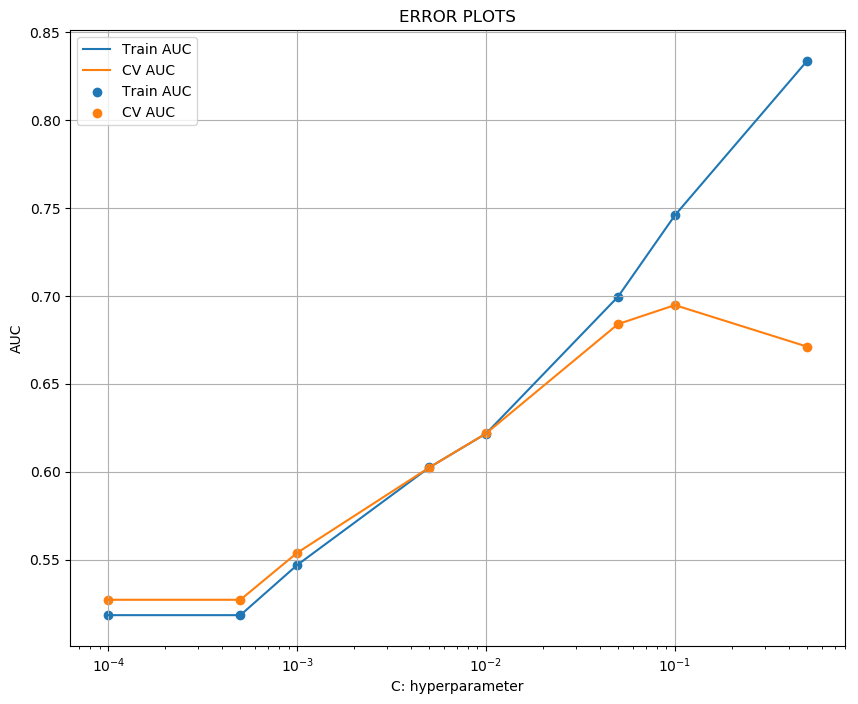

In [490]:

plt.figure(figsize=(10,8))
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC')
plt.scatter(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

In [491]:
from sklearn.model_selection import GridSearchCV
model=LogisticRegression()
parameters={'C':[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5],'penalty':['l1']}
clf=GridSearchCV(model,parameters,cv=10,scoring='roc_auc')
clf.fit(X_train_bow,y_train)

train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

In [492]:
best_params_bow=clf.best_params_['C']
print(best_params_bow)
print(clf.best_score_)
model=clf.best_estimator_

0.1
0.6830937554042188


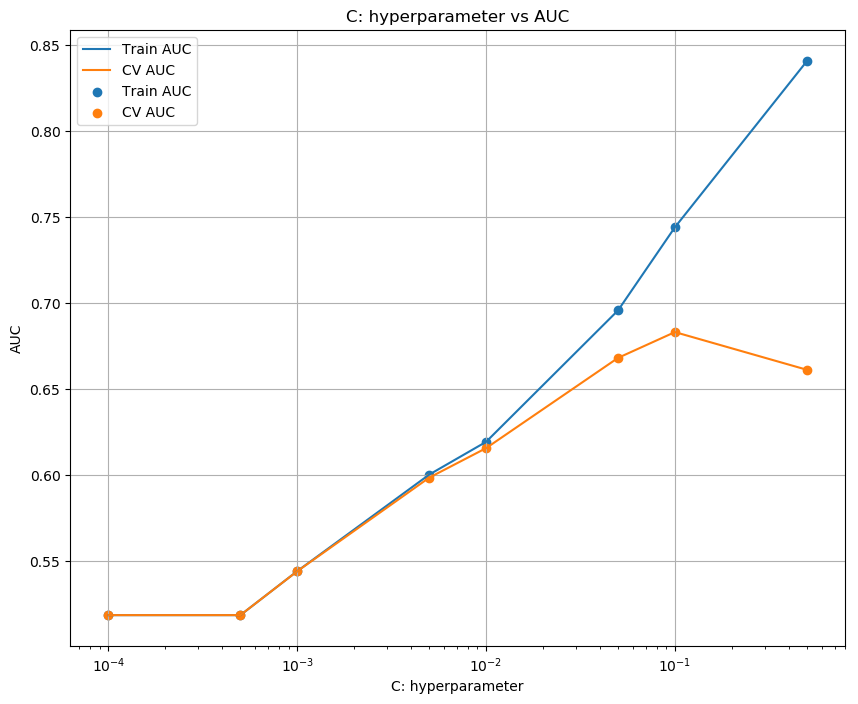

In [494]:
a=[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5]
plt.figure(figsize=(10,8))
plt.semilogx(a, train_auc, label='Train AUC')
plt.scatter(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')
plt.scatter(a, cv_auc, label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("C: hyperparameter vs AUC")
plt.show()

In [495]:
model.fit(X_train_bow,y_train)
y_train_pred=model.predict_proba(X_train_bow)[:,1]
y_test_pred=model.predict_proba(X_test_bow)[:,1]


train_fpr_bow,train_tpr_bow,train_thresholds_bow=roc_curve(y_train,y_train_pred)
test_fpr_bow,test_tpr_bow,test_thresholds_bow=roc_curve(y_test,y_test_pred)

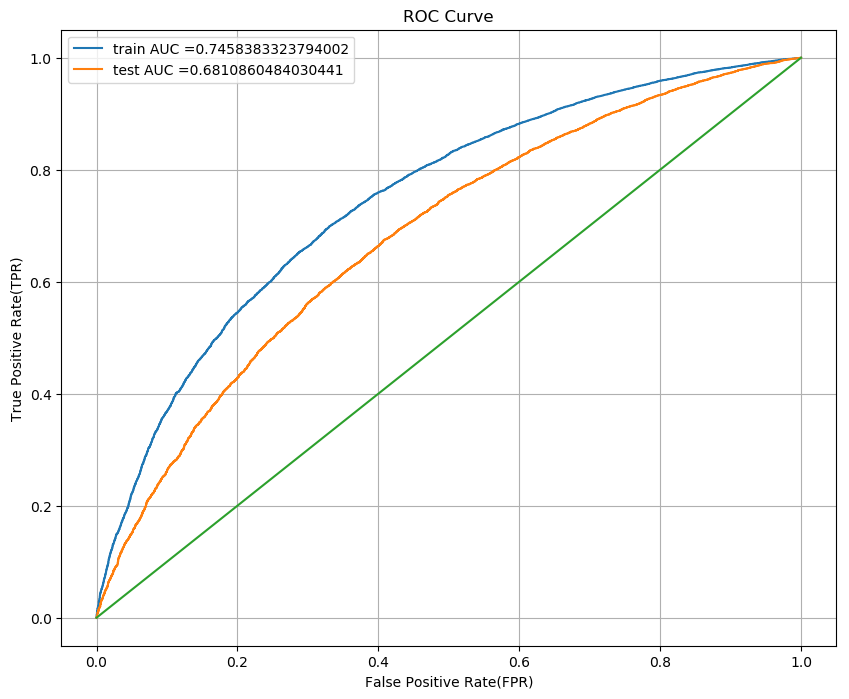

In [496]:
plt.figure(figsize=(10,8))
plt.style.use('default')
plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
avg_fpr=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
avg_tpr=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

plt.plot(avg_fpr, avg_tpr, label="avg AUC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [497]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba: 
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [498]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds_bow, train_fpr_bow, train_tpr_bow)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4680108400452515 for threshold 0.834
Train confusion matrix
[[ 4969  2456]
 [12512 29102]]
Test confusion matrix
[[ 3176  2283]
 [ 9748 20844]]


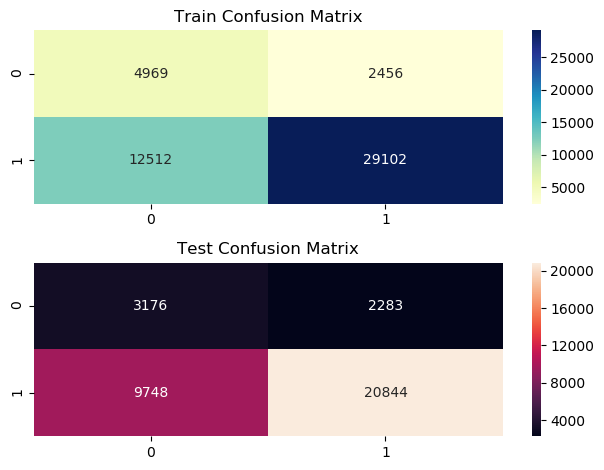

In [499]:
# cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

### Logistic Regression with tfidf

In [501]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc=[]
cv_auc=[]

C=[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5,1,10,20]
for i in tqdm(C):
    lr=LogisticRegression(C=i,penalty='l1')
    lr.fit(X_train_tfidf,y_train)
    y_train_pred=batch_predict(lr,X_train_tfidf)
    y_cv_pred = batch_predict(lr,X_cv_tfidf)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.61s/it]


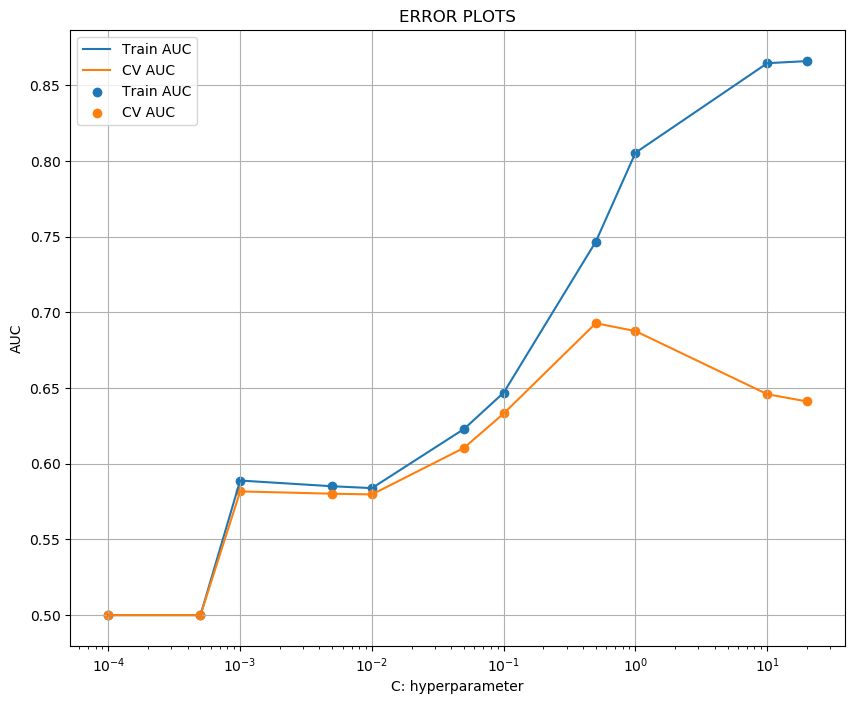

In [502]:

plt.figure(figsize=(10,8))
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC')
plt.scatter(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

In [503]:
from sklearn.model_selection import GridSearchCV
model=LogisticRegression()
parameters={'C':[ 0.01,0.05,0.1,0.5,1,10,20],'penalty':['l1']}
clf=GridSearchCV(model,parameters,cv=10,scoring='roc_auc')
clf.fit(X_train_tfidf,y_train)

train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

In [504]:
best_params_tfidf=clf.best_params_['C']
print(best_params_tfidf)
print(clf.best_score_)
model=clf.best_estimator_

1
0.6815425376982837


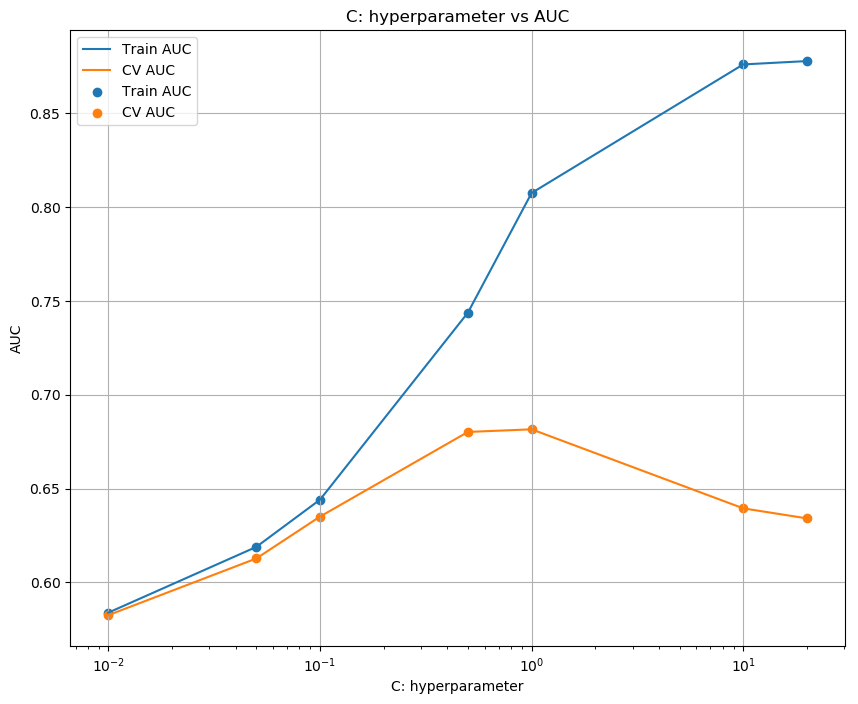

In [505]:
a=[ 0.01,0.05,0.1,0.5,1,10,20]
plt.figure(figsize=(10,8))
plt.semilogx(a, train_auc, label='Train AUC')
plt.scatter(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')
plt.scatter(a, cv_auc, label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("C: hyperparameter vs AUC")
plt.show()

In [506]:
model.fit(X_train_bow,y_train)
y_train_pred=model.predict_proba(X_train_tfidf)[:,1]
y_test_pred=model.predict_proba(X_test_tfidf)[:,1]


train_fpr_tfidf,train_tpr_tfidf,train_thresholds_tfidf=roc_curve(y_train,y_train_pred)
test_fpr_tfidf,test_tpr_tfidf,test_thresholds_tfidf=roc_curve(y_test,y_test_pred)

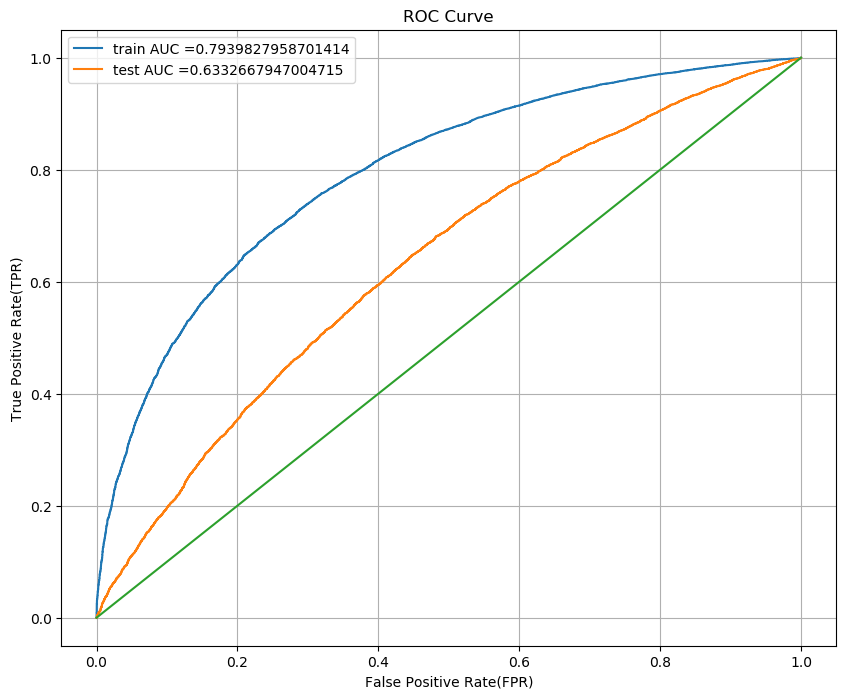

In [511]:
plt.figure(figsize=(10,8))
plt.style.use('default')
plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
avg_fpr=[0.0,1.0]
avg_tpr=[0.0,1.0]

plt.plot(avg_fpr, avg_tpr, label="avg AUC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [512]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_thresholds_tfidf, train_fpr_tfidf, train_tpr_tfidf)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5186228022523499 for threshold 0.753
Train confusion matrix
[[ 5289  2136]
 [11316 30298]]
Test confusion matrix
[[ 2771  2688]
 [ 9562 21030]]


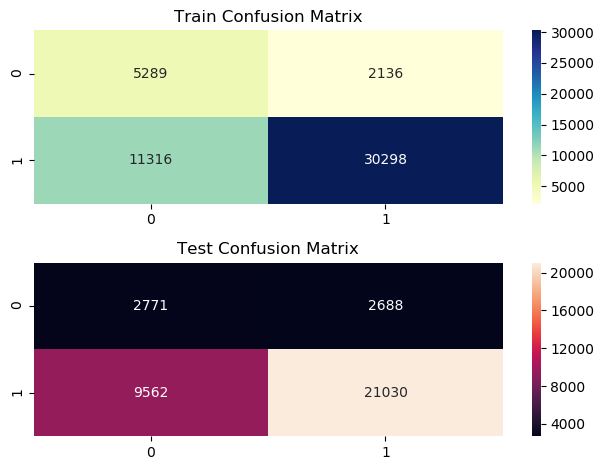

In [513]:
# cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

### Logistic Regression with avgw2vec

In [514]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc=[]
cv_auc=[]

C=[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5,1,10,20]
for i in tqdm(C):
    lr=LogisticRegression(C=i,penalty='l1')
    lr.fit(X_train_w2vec,y_train)
    y_train_pred=batch_predict(lr,X_train_w2vec)
    y_cv_pred = batch_predict(lr,X_cv_w2vec)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [26:26<00:00, 144.24s/it]


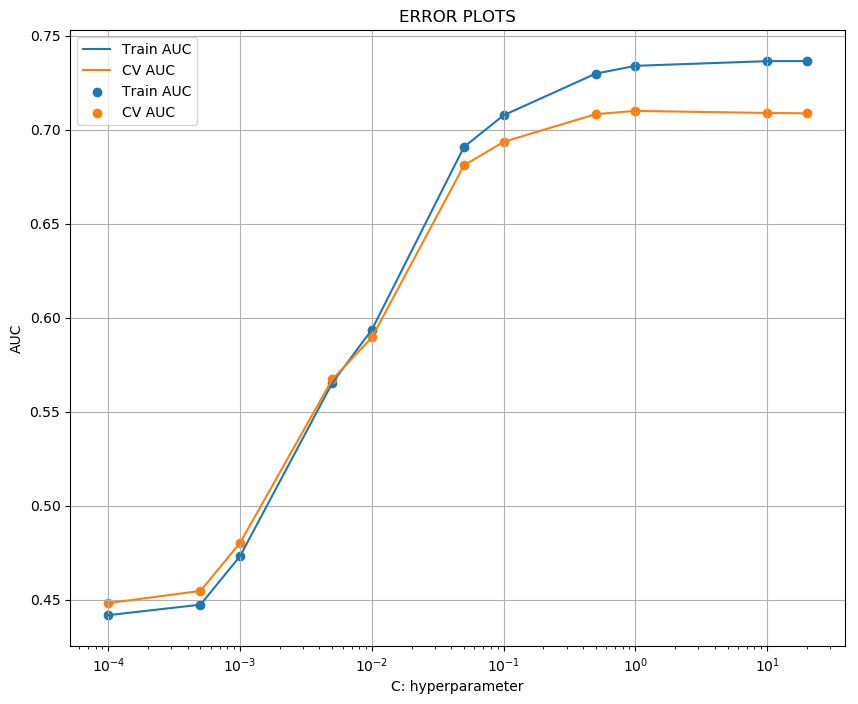

In [515]:
plt.figure(figsize=(10,8))
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC')
plt.scatter(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

In [516]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
parameters={'C':[ 0.01,0.05,0.1,0.5,1,10],'penalty':['l1']}
clf=GridSearchCV(model,parameters,cv=10,scoring='roc_auc',verbose=10)
clf.fit(X_train_w2vec,y_train)

train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.01, penalty=l1, score=0.5700166151095957, total=   3.2s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5887530777404745, total=   2.6s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] ...... C=0.01, penalty=l1, score=0.591960330698242, total=   3.0s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5941017331066245, total=   2.4s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV] ...... C=0.01, penalty=l1, score=0.588200437116686, total=   3.1s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5659188679893064, total=   2.8s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.6s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5893964039071573, total=   2.6s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.6014399529451699, total=   3.0s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.8s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5937323277177177, total=   3.0s
[CV] C=0.01, penalty=l1 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.0s remaining:    0.0s


[CV] ..... C=0.01, penalty=l1, score=0.5853435605037406, total=   3.1s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6622822136836325, total=  23.6s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6898316693431502, total=  27.8s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6820069163869995, total=  26.6s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6763749827801755, total=  27.7s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6889795424603841, total=  31.1s
[CV] C=0.05, penalty=l1 ..............................................
[CV] ..... C=0.05, penalty=l1, score=0.6725611521696462, total=  29.5s
[CV] C=0.05, penalty=l1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 127.7min finished


In [517]:
best_params_w2vec=clf.best_params_['C']
print(best_params_w2vec)
print(clf.best_score_)
model=clf.best_estimator_

1
0.7048782675065257


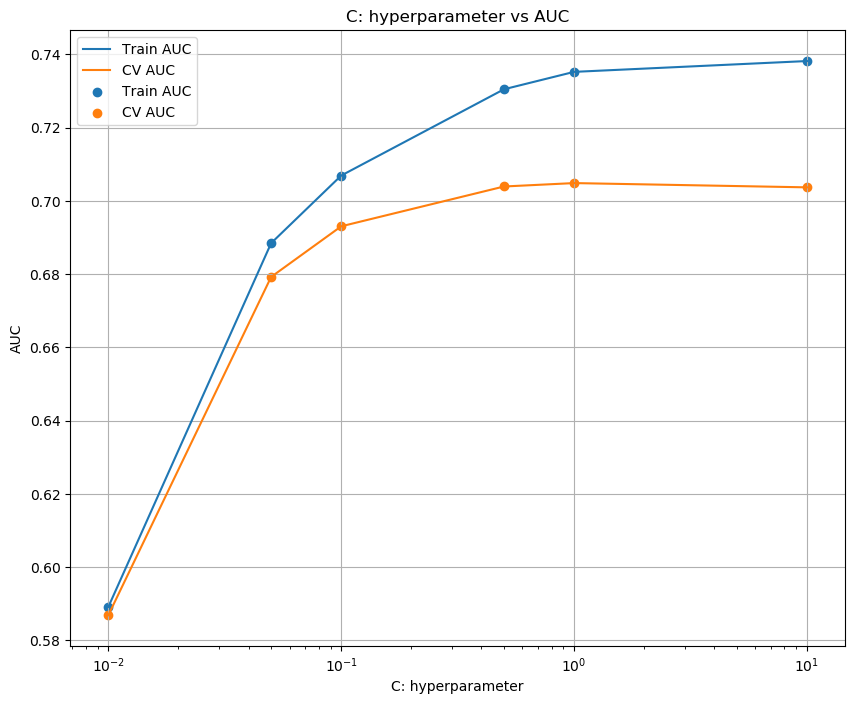

In [518]:
a=[0.01,0.05,0.1,0.5,1,10]
plt.figure(figsize=(10,8))
plt.semilogx(a, train_auc, label='Train AUC')
plt.scatter(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')
plt.scatter(a, cv_auc, label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("C: hyperparameter vs AUC")
plt.show()

In [519]:
model.fit(X_train_w2vec,y_train)
y_train_pred=model.predict_proba(X_train_w2vec)[:,1]
y_test_pred=model.predict_proba(X_test_w2vec)[:,1]

train_fpr_w2vec,train_tpr_w2vec,train_threshould_w2vec=roc_curve(y_train,y_train_pred)
test_fpr_w2vec,test_tpr_w2vec,test_threshould_w2vec=roc_curve(y_test,y_test_pred)

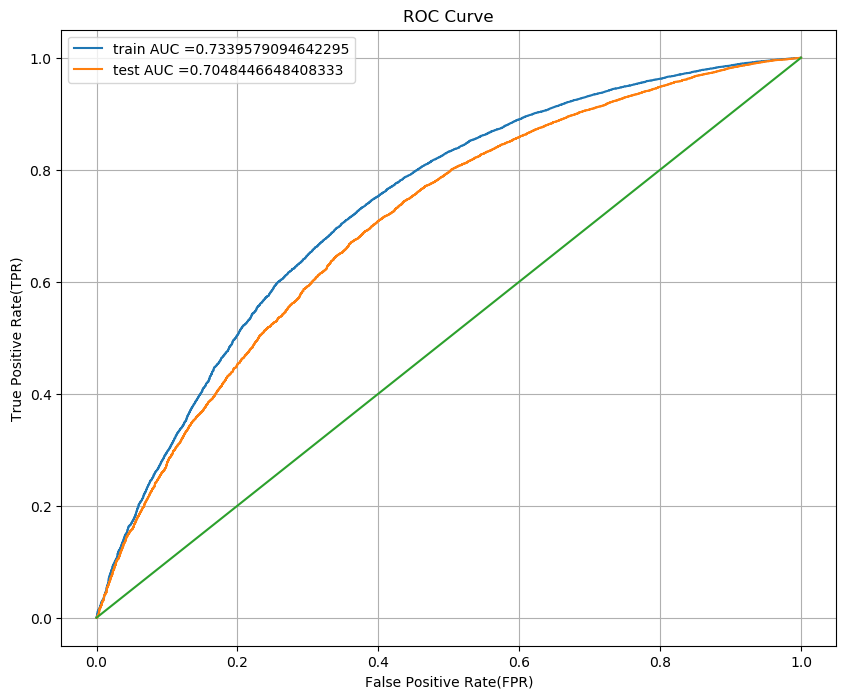

In [520]:
plt.figure(figsize=(10,8))
plt.style.use('default')
plt.plot(train_fpr_w2vec, train_tpr_w2vec, label="train AUC ="+str(auc(train_fpr_w2vec, train_tpr_w2vec)))
plt.plot(test_fpr_w2vec, test_tpr_w2vec, label="test AUC ="+str(auc(test_fpr_w2vec, test_tpr_w2vec)))
plt.legend()
avg_fpr=[0.0,1.0]
avg_tpr=[0.0,1.0]

plt.plot(avg_fpr, avg_tpr, label="avg AUC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [521]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshould_w2vec, train_fpr_w2vec, train_tpr_w2vec)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.458978840163057 for threshold 0.836
Train confusion matrix
[[ 4841  2584]
 [12319 29295]]
Test confusion matrix
[[ 3331  2128]
 [ 9241 21351]]


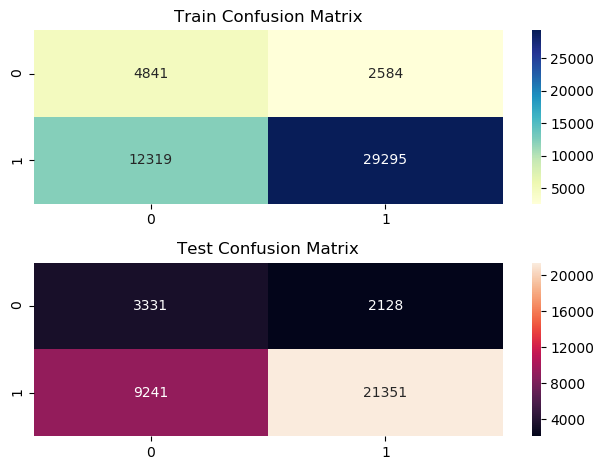

In [522]:
# cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

### Logistic Regression with tfidf w2vec

In [529]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc=[]
cv_auc=[]

C=[0.001,0.01,0.1,0.5,1,10]
for i in tqdm(C):
    lr=LogisticRegression(C=i,penalty='l1')
    lr.fit(X_train_tf_w2vec,y_train)
    y_train_pred=batch_predict(lr,X_train_tf_w2vec)
    y_cv_pred = batch_predict(lr,X_cv_tf_w2vec)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:40<00:00, 106.83s/it]


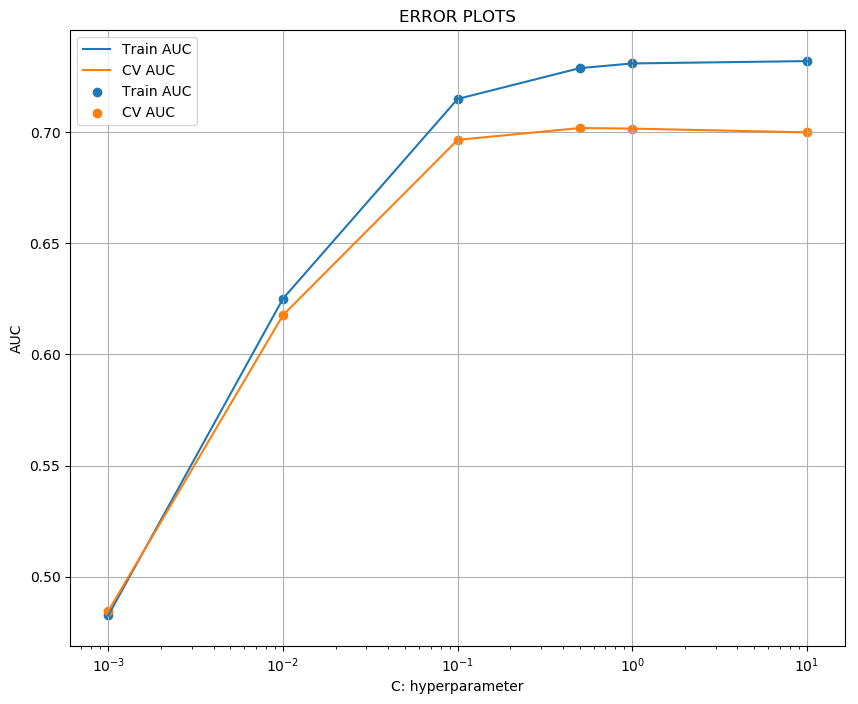

In [533]:
plt.figure(figsize=(10,8))
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC')
plt.scatter(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

In [537]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
parameters={'C':[0.01,0.05,0.1,0.5,1,10],'penalty':['l1']}
clf=GridSearchCV(model,parameters,cv=5,scoring='roc_auc',verbose=100)
clf.fit(X_train_tf_w2vec,y_train)

train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.01, penalty=l1 ..............................................
[CV] ...... C=0.01, penalty=l1, score=0.585187855162624, total=   9.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ...... C=0.01, penalty=l1, score=0.599122710140372, total=   2.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.5856462012895991, total=   2.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.6038622437276769, total=   2.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

In [539]:
best_params_tf_w2vec=clf.best_params_['C']
print(best_params_tf_w2vec)
print(clf.best_score_)
model=clf.best_estimator_

0.5
0.6986495940956968


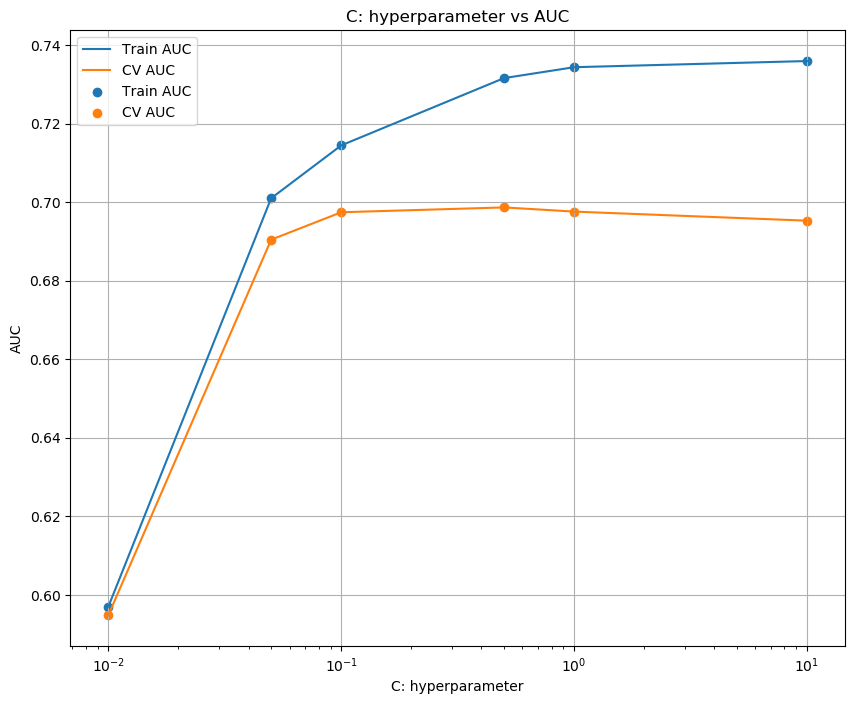

In [540]:
a=[0.01,0.05,0.1,0.5,1,10]
plt.figure(figsize=(10,8))
plt.semilogx(a, train_auc, label='Train AUC')
plt.scatter(a, train_auc, label='Train AUC')
plt.semilogx(a, cv_auc, label='CV AUC')
plt.scatter(a, cv_auc, label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("C: hyperparameter vs AUC")
plt.show()

In [541]:
model.fit(X_train_tf_w2vec,y_train)
y_train_pred=model.predict_proba(X_train_tf_w2vec)[:,1]
y_test_pred=model.predict_proba(X_test_tf_w2vec)[:,1]

train_fpr_tf_w2vec,train_tpr_tf_w2vec,train_threshould_tf_w2vec=roc_curve(y_train,y_train_pred)
test_fpr_tf_w2vec,test_tpr_tf_w2vec,test_threshould_tf_w2vec=roc_curve(y_test,y_test_pred)

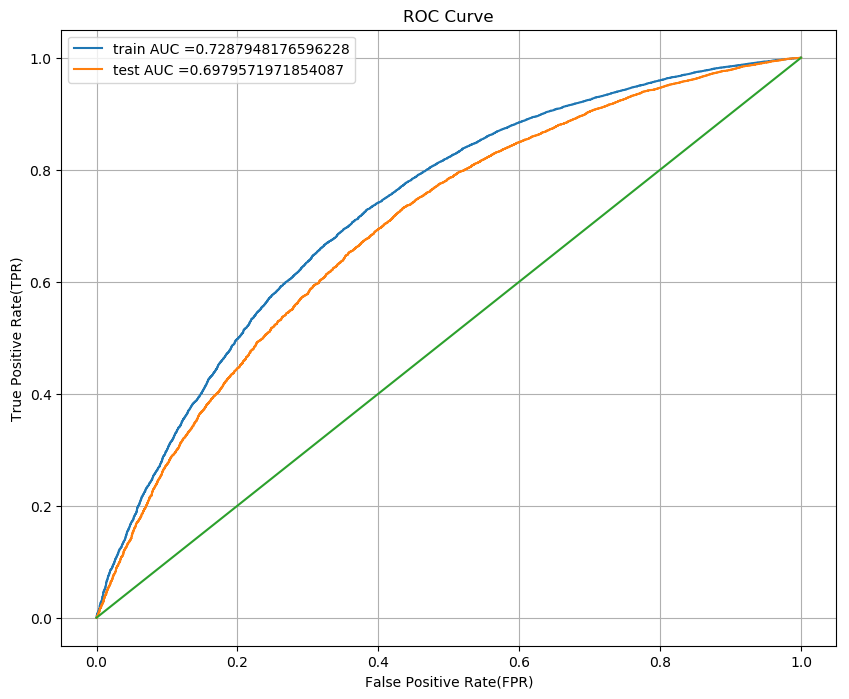

In [542]:
plt.figure(figsize=(10,8))
plt.style.use('default')
plt.plot(train_fpr_tf_w2vec, train_tpr_tf_w2vec, label="train AUC ="+str(auc(train_fpr_tf_w2vec, train_tpr_tf_w2vec)))
plt.plot(test_fpr_tf_w2vec, test_tpr_tf_w2vec, label="test AUC ="+str(auc(test_fpr_tf_w2vec, test_tpr_tf_w2vec)))
plt.legend()
avg_fpr=[0.0,1.0]
avg_tpr=[0.0,1.0]

plt.plot(avg_fpr, avg_tpr, label="avg AUC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [543]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshould_tf_w2vec, train_fpr_tf_w2vec, train_tpr_tf_w2vec)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.45050663634793975 for threshold 0.841
Train confusion matrix
[[ 5018  2407]
 [13874 27740]]
Test confusion matrix
[[ 3466  1993]
 [10479 20113]]


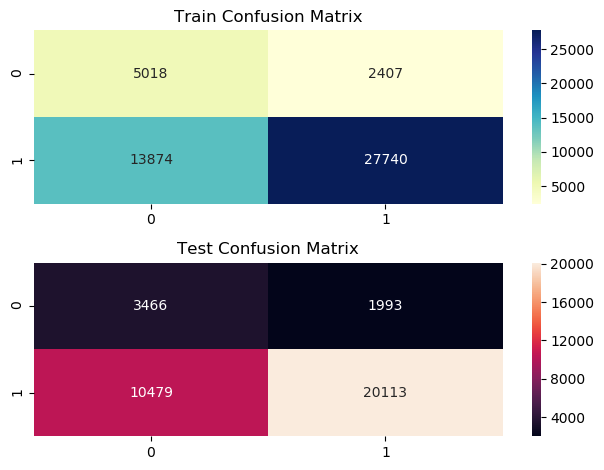

In [544]:
# cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

## Logistic Regression with following features
school_state : categorical data ,
clean_categories : categorical data ,
clean_subcategories : categorical data,
project_grade_category :categorical data,
teacher_prefix : categorical data,
quantity : numerical data,
teacher_number_of_previously_posted_projects : numerical data,
price : numerical data,
sentiment score's of each of the essay : numerical data,
number of words in the title : numerical data

In [548]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def polarity_sc(data):
    polar_essay=[]
    for i in data:
            pol_score=sid.polarity_scores(i)
            polar_essay.append(pol_score)
polarity_sc(X.essay)
dda=pd.DataFrame(polar_essay)
# dda.rename(columns={'neg':'essay_neg','neu':'essay_neu','pos':'essay_pos','compound':'title_essay_compound'})
dda.columns=['essay_neg','essay_neu','essay_pos','essay_compound']

In [549]:
def count_words(data):
    cnt_arr=[]
    for d in data:
        cnt=0
        cnt=len(d.split())
        cnt_arr.append(cnt)
    return cnt_arr

In [550]:
title_word_count=count_words(X.project_title)
dda['title_word']=title_word_count

essay_word_count=count_words(X.essay)
dda['essay_word']=essay_word_count

In [551]:
X_new=X.copy()
X_new=X_new.drop(['essay','project_title','project_resource_summary'],axis=1)
X_new=X_new.join(dda)
y_new=X_new.project_is_approved
X_new=X_new.drop(['project_is_approved'],axis=1)

In [552]:
from sklearn.model_selection import train_test_split

X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,y_new,test_size=0.33,stratify=y_new)
X_new_train,X_new_cv,y_new_train,y_new_cv=train_test_split(X_new_train,y_new_train,test_size=0.33,stratify=y_new_train)


In [553]:
print('X Train shape',X_new_train.shape)
print('Y Train shape',y_new_train.shape)
print('X Test shape',X_new_test.shape)
print('Y Test shape',y_new_test.shape)
print('X cv shape',X_new_cv.shape)
print('y CV shape',y_new_cv.shape)

X Train shape (49039, 13)
Y Train shape (49039,)
X Test shape (36051, 13)
Y Test shape (36051,)
X cv shape (24155, 13)
y CV shape (24155,)


In [554]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()
vectorizer.fit(X_new_train['school_state'])
X_new_train_school_state=vectorizer.transform(X_new_train['school_state'])
X_new_test_school_state=vectorizer.transform(X_new_test['school_state'])
X_new_cv_school_state=vectorizer.transform(X_new_cv['school_state'])

print(X_new_train_school_state.shape,y_new_train.shape)
print(X_new_test_school_state.shape,y_new_test.shape)
print(X_new_cv_school_state.shape,y_new_cv.shape)

(49039, 51) (49039,)
(36051, 51) (36051,)
(24155, 51) (24155,)


In [555]:
vectorizer=CountVectorizer()
vectorizer.fit(X_new_train['clean_categories'])
X_new_train_clean_categories=vectorizer.transform(X_new_train['clean_categories'])
X_new_test_clean_categories=vectorizer.transform(X_new_test['clean_categories'])
X_new_cv_clean_categories=vectorizer.transform(X_new_cv['clean_categories'])

print(X_new_train_clean_categories.shape,y_new_train.shape)
print(X_new_test_clean_categories.shape,y_new_test.shape)
print(X_new_cv_clean_categories.shape,y_new_cv.shape)

(49039, 9) (49039,)
(36051, 9) (36051,)
(24155, 9) (24155,)


In [556]:
vectorizer=CountVectorizer()
vectorizer.fit(X_new_train['clean_subcategories'])
X_new_train_clean_subcategories=vectorizer.transform(X_new_train['clean_subcategories'])
X_new_test_clean_subcategories=vectorizer.transform(X_new_test['clean_subcategories'])
X_new_cv_clean_subcategories=vectorizer.transform(X_new_cv['clean_subcategories'])

print(X_new_train_clean_subcategories.shape,y_train.shape)
print(X_new_test_clean_subcategories.shape,y_test.shape)
print(X_new_cv_clean_subcategories.shape,y_cv.shape)

(49039, 30) (49039,)
(36051, 30) (36051,)
(24155, 30) (24155,)


In [557]:
vectorizer=CountVectorizer()
vectorizer.fit(X_new_train['teacher_prefix'].unique())
X_new_train_teacher_prefix=vectorizer.transform(X_new_train['teacher_prefix'])
X_new_test_teacher_prefix=vectorizer.transform(X_new_test['teacher_prefix'])
X_new_cv_teacher_prefix=vectorizer.transform(X_new_cv['teacher_prefix'])

print(X_new_train_teacher_prefix.shape,y_train.shape)
print(X_new_test_teacher_prefix.shape,y_test.shape)
print(X_new_cv_teacher_prefix.shape,y_cv.shape)

(49039, 5) (49039,)
(36051, 5) (36051,)
(24155, 5) (24155,)


In [558]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

lbl=LabelEncoder()
lbl.fit(X_new_train['project_grade_category'].values)

grade_train_lbl=lbl.transform(X_new_train['project_grade_category'].values)
grade_test_lbl=lbl.transform(X_new_test['project_grade_category'].values)
grade_cv_lbl=lbl.transform(X_new_cv['project_grade_category'].values)

ohe=OneHotEncoder()
ohe.fit(grade_train_lbl.reshape(-1,1))
X_new_train_project_grade_category=ohe.transform(grade_train_lbl.reshape(-1,1)).astype(int)
X_new_test_project_grade_category=ohe.transform(grade_test_lbl.reshape(-1,1)).astype(int)
X_new_cv_project_grade_category=ohe.transform(grade_cv_lbl.reshape(-1,1)).astype(int)

print(X_new_train_project_grade_category.shape,y_train.shape)
print(X_new_test_project_grade_category.shape,y_test.shape)
print(X_new_cv_project_grade_category.shape,y_cv.shape)

(49039, 4) (49039,)
(36051, 4) (36051,)
(24155, 4) (24155,)


In [559]:
from sklearn.preprocessing import MinMaxScaler

price_scalar = MinMaxScaler()
price_scalar.fit(X_new_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
X_new_train_price_normalized = price_scalar.transform(X_new_train['price'].values.reshape(-1, 1))
X_new_test_price_normalized = price_scalar.transform(X_new_test['price'].values.reshape(-1, 1))
X_new_cv_price_normalized = price_scalar.transform(X_new_cv['price'].values.reshape(-1, 1))

print(X_new_train_price_normalized.shape,y_train.shape)
print(X_new_test_price_normalized.shape,y_test.shape)
print(X_new_cv_price_normalized.shape,y_cv.shape)

(49039, 1) (49039,)
(36051, 1) (36051,)
(24155, 1) (24155,)


In [560]:
from sklearn.preprocessing import MinMaxScaler

posted_projects_scalar = MinMaxScaler()
posted_projects_scalar.fit(X_new_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
X_new_train_posted_projects_normalized = posted_projects_scalar.transform(X_new_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_new_test_posted_projects_normalized = posted_projects_scalar.transform(X_new_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_new_cv_posted_projects_normalized = posted_projects_scalar.transform(X_new_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

print(X_new_train_posted_projects_normalized.shape,y_train.shape)
print(X_new_test_posted_projects_normalized.shape,y_test.shape)
print(X_new_cv_posted_projects_normalized.shape,y_cv.shape)

(49039, 1) (49039,)
(36051, 1) (36051,)
(24155, 1) (24155,)


C:\Users\Vishal Gym\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [561]:
from sklearn.preprocessing import MinMaxScaler

title_word_scalar = MinMaxScaler()
title_word_scalar.fit(X_new_train['title_word'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
X_new_train_title_word_normalized = title_word_scalar.transform(X_new_train['title_word'].values.reshape(-1, 1))
X_new_test_title_word_normalized = title_word_scalar.transform(X_new_test['title_word'].values.reshape(-1, 1))
X_new_cv_title_word_normalized = title_word_scalar.transform(X_new_cv['title_word'].values.reshape(-1, 1))

print(X_new_train_title_word_normalized.shape,y_train.shape)
print(X_new_test_title_word_normalized.shape,y_test.shape)
print(X_new_cv_title_word_normalized.shape,y_cv.shape)

(49039, 1) (49039,)
(36051, 1) (36051,)
(24155, 1) (24155,)


C:\Users\Vishal Gym\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [562]:
from sklearn.preprocessing import MinMaxScaler

essay_word_scalar = MinMaxScaler()
essay_word_scalar.fit(X_new_train['essay_word'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

# Now standardize the data with above maen and variance.
X_new_train_essay_word_normalized = essay_word_scalar.transform(X_new_train['essay_word'].values.reshape(-1, 1))
X_new_test_essay_word_normalized = essay_word_scalar.transform(X_new_test['essay_word'].values.reshape(-1, 1))
X_new_cv_essay_word_normalized = essay_word_scalar.transform(X_new_cv['essay_word'].values.reshape(-1, 1))

print(X_new_train_essay_word_normalized.shape,y_train.shape)
print(X_new_test_essay_word_normalized.shape,y_test.shape)
print(X_new_cv_essay_word_normalized.shape,y_cv.shape)

(49039, 1) (49039,)
(36051, 1) (36051,)
(24155, 1) (24155,)


C:\Users\Vishal Gym\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [563]:
X_new_train_set_5=hstack((X_new_train_school_state,X_new_train_clean_categories,X_new_train_clean_subcategories,X_new_train_teacher_prefix,X_new_train_project_grade_category,X_new_train_price_normalized,X_new_train_posted_projects_normalized,X_new_train_title_word_normalized,X_new_train_essay_word_normalized,X_new_train.essay_neg.as_matrix().reshape(-1,1),X_new_train.essay_neu.as_matrix().reshape(-1,1),X_new_train.essay_pos.as_matrix().reshape(-1,1),X_new_train.essay_compound.as_matrix().reshape(-1,1)
)).tocsr()
X_new_test_set_5=hstack((X_new_test_school_state,X_new_test_clean_categories,X_new_test_clean_subcategories,X_new_test_teacher_prefix,X_new_test_project_grade_category,X_new_test_price_normalized,X_new_test_posted_projects_normalized,X_new_test_title_word_normalized,X_new_test_essay_word_normalized,X_new_test.essay_neg.as_matrix().reshape(-1,1),X_new_test.essay_neu.as_matrix().reshape(-1,1),X_new_test.essay_pos.as_matrix().reshape(-1,1),X_new_test.essay_compound.as_matrix().reshape(-1,1)
)).tocsr()
X_new_cv_set_5=hstack((X_new_cv_school_state,X_new_cv_clean_categories,X_new_cv_clean_subcategories,X_new_cv_teacher_prefix,X_new_cv_project_grade_category,X_new_cv_price_normalized,X_new_cv_posted_projects_normalized,X_new_cv_title_word_normalized,X_new_cv_essay_word_normalized,X_new_cv.essay_neg.as_matrix().reshape(-1,1),X_new_cv.essay_neu.as_matrix().reshape(-1,1),X_new_cv.essay_pos.as_matrix().reshape(-1,1),X_new_cv.essay_compound.as_matrix().reshape(-1,1))).tocsr()

print(X_new_train_set_5.shape)
print(X_new_test_set_5.shape)
print(X_new_cv_set_5.shape)

(49039, 107)
(36051, 107)
(24155, 107)


In [566]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc=[]
cv_auc=[]

C=[0.0001,0.0005,0.001, 0.005, 0.01,0.05,0.1,0.5,1,10]
for i in tqdm(C):
    lr=LogisticRegression(C=i,penalty='l1')
    lr.fit(X_new_train_set_5,y_new_train)
    y_train_pred=batch_predict(lr,X_new_train_set_5)
    y_cv_pred = batch_predict(lr,X_new_cv_set_5)
    
    train_auc.append(roc_auc_score(y_new_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_new_cv,y_cv_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


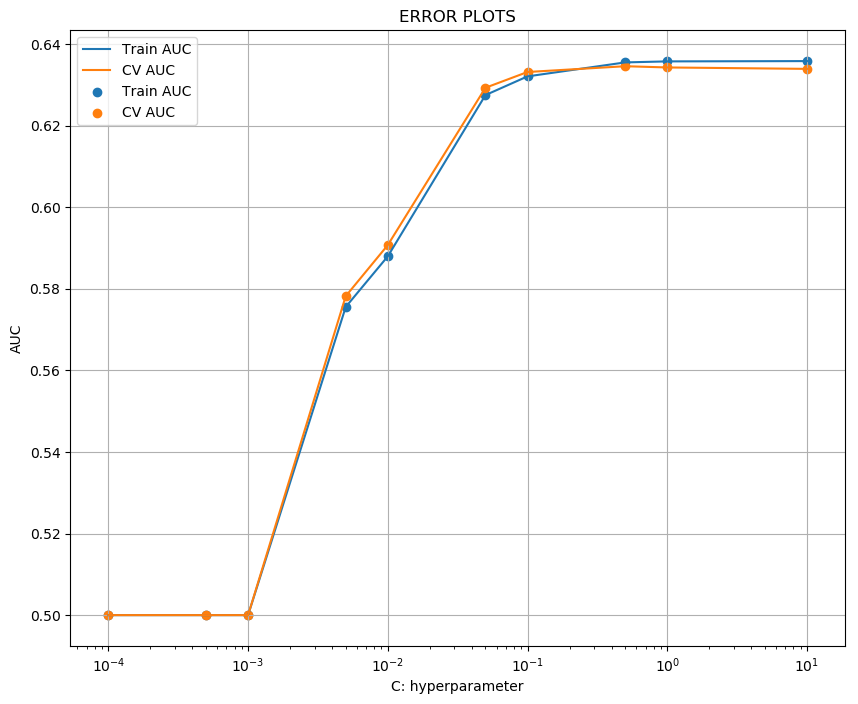

In [567]:
plt.figure(figsize=(10,8))
plt.semilogx(C, train_auc, label='Train AUC')
plt.semilogx(C, cv_auc, label='CV AUC')
plt.scatter(C, train_auc, label='Train AUC')
plt.scatter(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.grid()
plt.title("ERROR PLOTS")
plt.show()

In [568]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
parameters={'C':[ 0.01,0.05,0.1,0.5,1],'penalty':['l1']}
clf=GridSearchCV(model,parameters,cv=10,scoring='roc_auc',verbose=100)
clf.fit(X_new_train_set_5,y_new_train)

train_auc=clf.cv_results_['mean_train_score']
cv_auc=clf.cv_results_['mean_test_score']

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.5915004886226274, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.5655342866918083, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.5912896468270574, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.01, penalty=l1, score=0.5933369465322021, total=   0.6s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

[CV] ...... C=0.5, penalty=l1, score=0.6383573303898153, total=   3.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   46.9s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ...... C=0.5, penalty=l1, score=0.6280193893884363, total=   6.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   53.1s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ...... C=0.5, penalty=l1, score=0.6093623176576748, total=   3.1s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   56.4s remaining:    0.0s
[CV] C=0.5, penalty=l1 ...............................................
[CV] ...... C=0.5, penalty=l1, score=0.6235960151088499, total=   7.3s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min remaining:    0.0s
[CV] C=1, penalty=l1 .................................................
[CV] ........ C=1, penalty=l1, score=0.6383490828705269, total=   6.2s
[Parallel(n_jobs=1)]: Done  41 out of  41

In [569]:
best_params_set5=clf.best_params_['C']
print(best_params_set5)
print(clf.best_score_)
model=clf.best_estimator_

0.5
0.6265250305716241


In [570]:
model.fit(X_new_train_set_5,y_new_train)
y_train_pred=model.predict_proba(X_new_train_set_5)[:,1]
y_test_pred=model.predict_proba(X_new_test_set_5)[:,1]

train_fpr_set5,train_tpr_set5,train_threshould_set5=roc_curve(y_new_train,y_train_pred)
test_fpr_set5,test_tpr_set5,test_threshould_set5=roc_curve(y_new_test,y_test_pred)

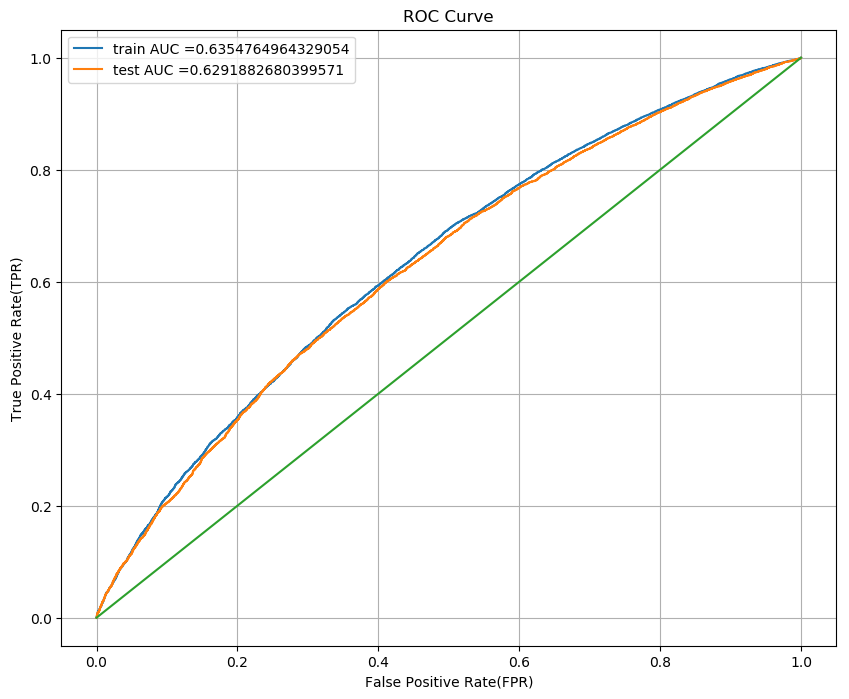

In [571]:
plt.figure(figsize=(10,8))
plt.style.use('default')
plt.plot(train_fpr_set5, train_tpr_set5, label="train AUC ="+str(auc(train_fpr_set5, train_tpr_set5)))
plt.plot(test_fpr_set5, test_tpr_set5, label="test AUC ="+str(auc(test_fpr_set5, test_tpr_set5)))
plt.legend()
avg_fpr=[0.0,1.0]
avg_tpr=[0.0,1.0]

plt.plot(avg_fpr, avg_tpr, label="avg AUC")
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [572]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(train_threshould_set5, train_fpr_set5, train_tpr_set5)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.3568524578703845 for threshold 0.846
Train confusion matrix
[[ 3205  4220]
 [18290 23324]]
Test confusion matrix
[[ 2388  3071]
 [13459 17133]]


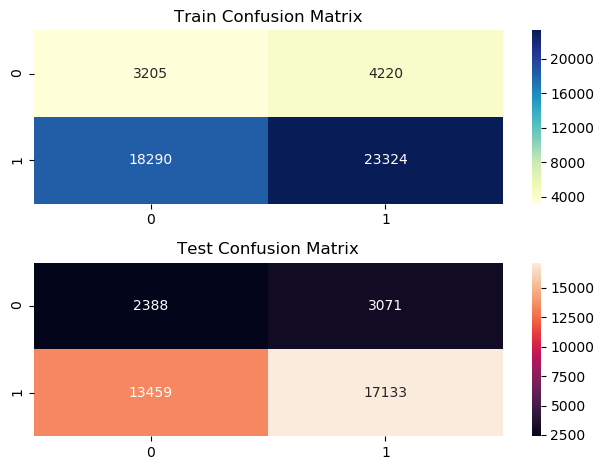

In [573]:
# cite:
# http://seaborn.pydata.org/generated/seaborn.heatmap.html -- Heat maps
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib -- tight layout for spacing

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title('Train Confusion Matrix')
ax2.set_title('Test Confusion Matrix')
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True ,fmt = 'd', ax = ax1,cmap="YlGnBu")
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True ,fmt = 'd', ax= ax2)# #annot=True to annotate cells
fig.tight_layout()

<h1>3. Conclusion</h1>

In [574]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
pt=PrettyTable(['Vectorizer','Model','Hyperparameter(C)','Train Auc','Test AUC'])
pt.add_row(['BoW','LOgistic Regression',best_params_bow,round(auc(train_fpr_bow, train_tpr_bow),3),round(auc(test_fpr_bow, test_tpr_bow),3)])
pt.add_row(['Tf-idf','LOgistic Regression',best_params_tfidf,round(auc(train_fpr_tfidf, train_tpr_tfidf),3),round(auc(test_fpr_tfidf, test_tpr_tfidf),3)])
pt.add_row(['avg-w2vec','LOgistic Regression',best_params_w2vec,round(auc(train_fpr_w2vec, train_tpr_w2vec),3),round(auc(test_fpr_w2vec, test_tpr_w2vec),3)])
pt.add_row(['tf-avg-w2vec','LOgistic Regression',best_params_tf_w2vec,round(auc(train_fpr_tf_w2vec, train_tpr_tf_w2vec),3),round(auc(test_fpr_tf_w2vec, test_tpr_tf_w2vec),3)])
pt.add_row(['POlarity scores','LOgistic Regression',best_params_set5,round(auc(train_fpr_set5, train_tpr_set5),3),round(auc(test_fpr_set5, test_tpr_set5),3)])


In [575]:
print(pt)

+-----------------+---------------------+-------------------+-----------+----------+
|    Vectorizer   |        Model        | Hyperparameter(C) | Train Auc | Test AUC |
+-----------------+---------------------+-------------------+-----------+----------+
|       BoW       | LOgistic Regression |        0.1        |   0.746   |  0.681   |
|      Tf-idf     | LOgistic Regression |         1         |   0.794   |  0.633   |
|    avg-w2vec    | LOgistic Regression |         1         |   0.734   |  0.705   |
|   tf-avg-w2vec  | LOgistic Regression |        0.5        |   0.729   |  0.698   |
| POlarity scores | LOgistic Regression |        0.5        |   0.635   |  0.629   |
+-----------------+---------------------+-------------------+-----------+----------+
